In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from sklearn.metrics import r2_score
import sys

sys.path.append('..')

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Test System

In [431]:
def bidirectional_causality(tau_d=0, T=3000, x0=[0.2, 0.4]):
    x = np.zeros((T, 2))
    x[0] = x0
    for t in range(T-1):
        x[t + 1][0] = x[t][0]*(3.78 - 3.78*x[t][0] - 0.07*x[t][1])
        if t - tau_d >= 0:
            x[t + 1][1] = x[t][1]*(3.78 - 3.78*x[t][1] - 0.08*x[t - tau_d][0])
        else:
            x[t + 1][1] = x[t][1]*(3.78 - 3.78*x[t][1])
    
    return x

In [432]:
x = bidirectional_causality(tau_d=10)

In [433]:
x = (x - x.mean())/x.std()

### DeLASE

In [439]:
delase = DeLASE(x, p=50, use_torch=True, device='cuda')

In [440]:
delase.compute_havok_dmd(explained_variance=0.9999, use_bias=False)

In [441]:
preds = delase.predict_havok_dmd(x, use_real_coords=True)

In [442]:
r2_metric(x[delase.p:], preds[delase.p:])

array([0.55986755, 0.56722296])

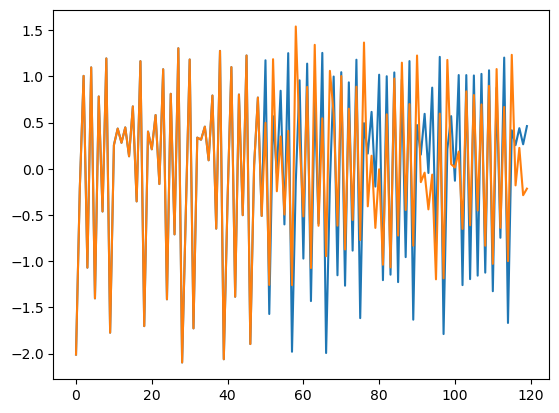

In [443]:
plt.plot(x[:120, 0])
plt.plot(preds[:120, 0].cpu())

In [444]:
proj_x_to_y = delase.A[np.arange(1, delase.A.shape[0], 2), :][:, np.arange(0, delase.A.shape[0], 2)]
proj_y_to_x = delase.A[np.arange(0, delase.A.shape[0], 2), :][:, np.arange(1, delase.A.shape[0], 2)]

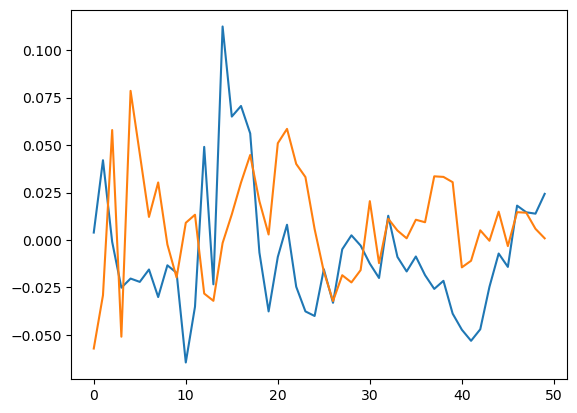

In [445]:
plt.plot(proj_x_to_y.cpu()[0])
plt.plot(proj_y_to_x.cpu()[0])

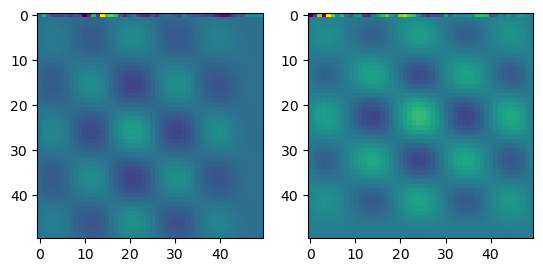

In [446]:
plt.subplot(1, 2, 1)
plt.imshow(proj_x_to_y.cpu())
plt.subplot(1, 2, 2)
plt.imshow(proj_y_to_x.cpu())

In [447]:
U, S, Vh = torch.linalg.svd(proj_x_to_y)

V = Vh.T.cpu()

In [448]:
S = S.cpu()
explained_variance = torch.cumsum(S**2/((S**2).sum()), 0)
subspace_dim = int(np.argmax(explained_variance > 0.9999))
subspace_dim

2

In [449]:
scaled_pcs = (torch.diag_embed(S.cuda())@Vh).T

In [450]:
x_projs = (scaled_pcs.T @ delase.H[:, np.arange(0, delase.H.shape[1], 2)].T).T

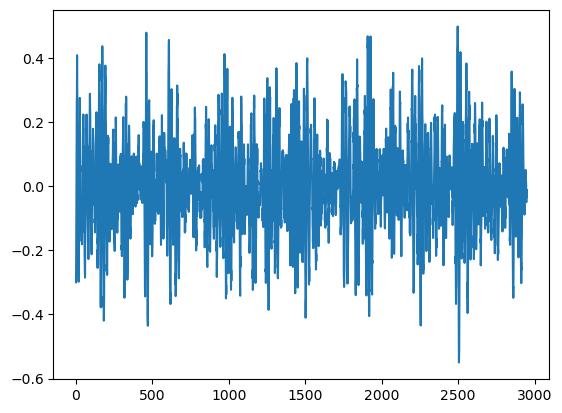

In [454]:
plt.plot(x_projs[:,0].cpu())

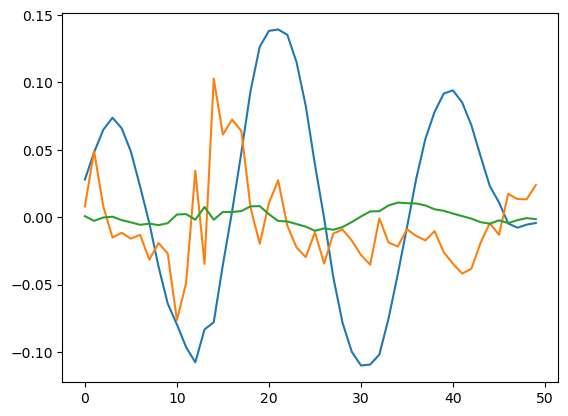

In [452]:
plt.plot(scaled_pcs[:, 0].cpu())
plt.plot(scaled_pcs[:, 1].cpu())
plt.plot(scaled_pcs[:, 2].cpu())
plt.show()

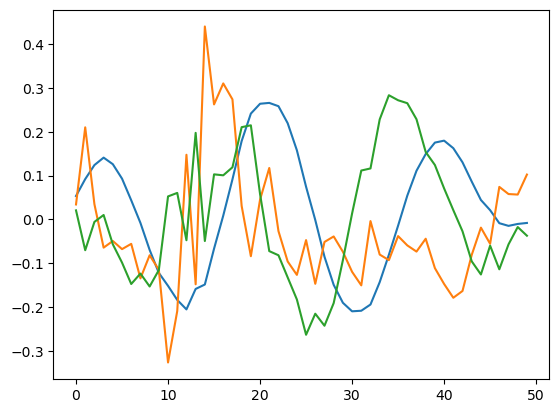

In [453]:
plt.plot(V[:, 0])
plt.plot(V[:, 1])
plt.plot(V[:, 2])

### Prediction Directly

In [474]:
p = 100
H_x = embed_signal(x[:, [0]], p, use_torch=True, device='cuda')
H_y = embed_signal(x[:, [1]], p, use_torch=True, device='cuda')

In [475]:
H_x.shape, H_y.shape

(torch.Size([2901, 100]), torch.Size([2901, 100]))

In [476]:
U, S, Vh = torch.linalg.svd(H_x.T)

In [477]:
B_OLS = (torch.linalg.inv(H_x.T@H_x)@H_x.T@H_y).T

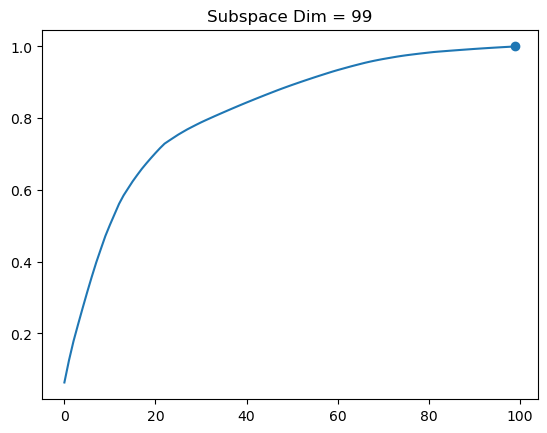

In [496]:
S = S.cpu()
explained_variance = torch.cumsum(S**2/((S**2).sum()), 0)
subspace_dim = int(np.argmax(explained_variance >= 1))

plt.plot(explained_variance)
plt.scatter(subspace_dim, explained_variance[subspace_dim])
plt.title(f'Subspace Dim = {subspace_dim}')
plt.show()

In [497]:
B_RRR = B_OLS@U[:, :subspace_dim]@U[:, :subspace_dim].T

In [498]:
B_RRR.shape

torch.Size([100, 100])

In [499]:
preds = (B_RRR@H_x.T).T

In [500]:
r2_overall = r2_metric(H_y, preds).mean()
r2_overall

0.180283

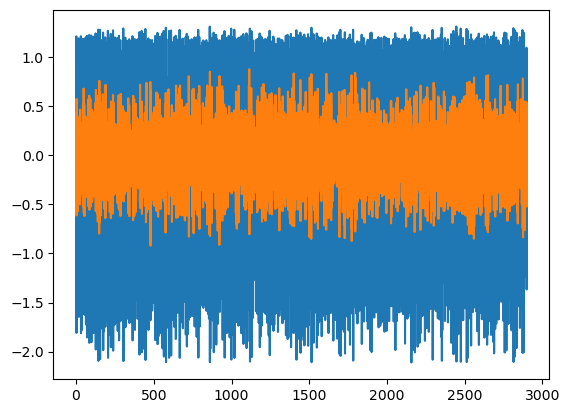

In [501]:
plt.plot(H_y[:, 0].cpu())
plt.plot(preds.cpu()[:, 0])

In [534]:
proj_coefs = torch.zeros(B_RRR.shape[0]*2).cuda()
num = torch.zeros(proj_coefs.shape).cuda()
for i in range(B_RRR.shape[0]):
    proj_coefs[i:i + B_RRR.shape[0]] += torch.abs(torch.flip(B_RRR[i], (0,)))
    num[i:i + B_RRR.shape[0]] += 1
proj_magnitude = (proj_coefs/num).cpu())

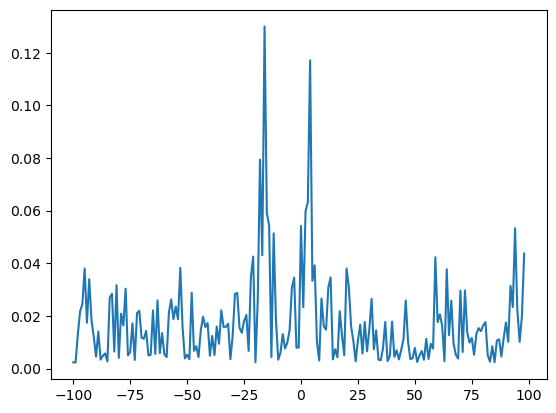

In [535]:
plt.plot(torch.arange(-B_RRR.shape[0], B_RRR.shape[0]), 

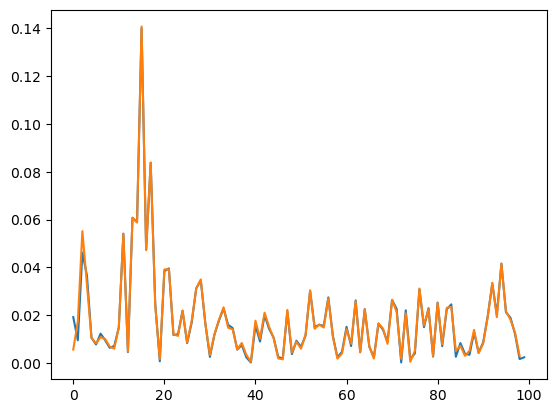

In [523]:
plt.plot(np.abs(B_RRR[0].cpu()))
plt.plot(np.abs(B_RRR[1][1:].cpu()))

plt.show()

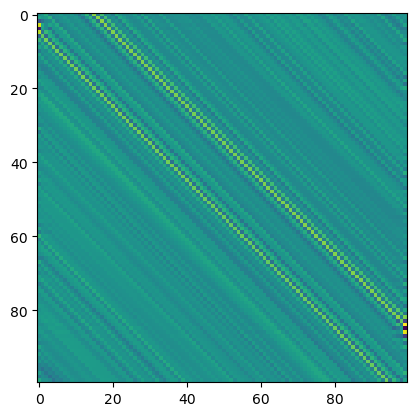

In [503]:
plt.imshow(B_RRR.cpu())

In [504]:
U, S, Vh = torch.linalg.svd(B_RRR)

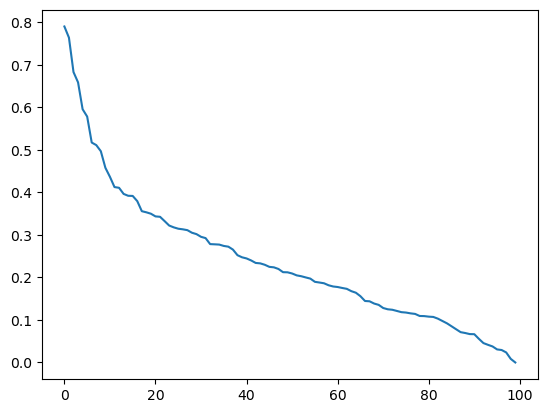

In [505]:
plt.plot(S.cpu())

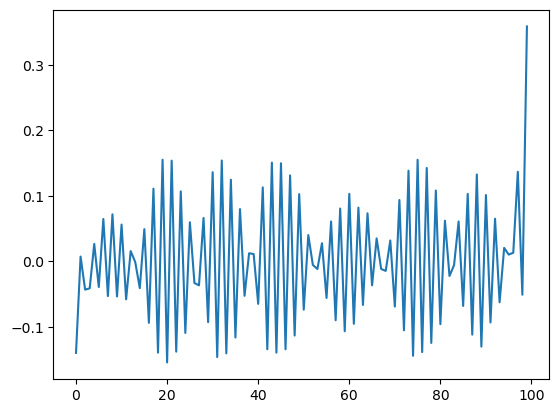

In [508]:
plt.plot(Vh[2].cpu())

### Looping

In [537]:
def compute_proj_mags(B):
    proj_coefs = torch.zeros(B.shape[0]*2).cuda()
    num = torch.zeros(proj_coefs.shape).cuda()
    for i in range(B.shape[0]):
        proj_coefs[i:i + B.shape[0]] += torch.abs(torch.flip(B[i], (0,)))
        num[i:i + B.shape[0]] += 1
    proj_magnitude = (proj_coefs/num).cpu()
    
    return proj_magnitude

In [538]:
p = 100
results = []
for tau_d in tqdm([0, 5, 10, 15, 20]):
    x = bidirectional_causality(tau_d=tau_d)
    x = (x - x.mean())/x.std()

    H_x = embed_signal(x[:, [0]], p, use_torch=True, device='cuda')
    H_y = embed_signal(x[:, [1]], p, use_torch=True, device='cuda')
    
    B_OLS_x_to_y = (torch.linalg.inv(H_x.T@H_x)@H_x.T@H_y).T
    B_OLS_y_to_x = (torch.linalg.inv(H_y.T@H_y)@H_y.T@H_x).T
    
    proj_mag_x_to_y = compute_proj_mags(B_OLS_x_to_y)
    proj_mag_y_to_x = compute_proj_mags(B_OLS_y_to_x)
    
    results.append(dict(
        tau_d=tau_d,
        B_OLS_x_to_y=B_OLS_x_to_y.cpu(),
        B_OLS_y_to_x=B_OLS_y_to_x.cpu(),
        proj_mag_x_to_y=proj_mag_x_to_y,
        proj_mag_y_to_x=proj_mag_y_to_x
    ))

  0%|          | 0/5 [00:00<?, ?it/s]

In [539]:
results = pd.DataFrame(results)

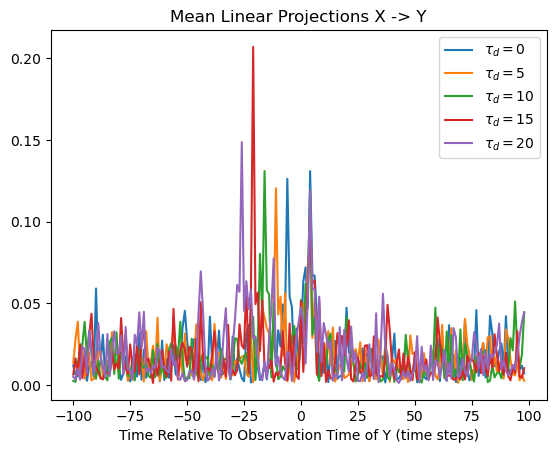

In [544]:
for i, row in results.iterrows():
    plt.plot(torch.arange(-p, p), row.proj_mag_x_to_y, label=r"$\tau_d = $" + f"{row.tau_d}")
plt.title('Mean Linear Projections X -> Y')
plt.xlabel('Time Relative To Observation Time of Y (time steps)')
plt.legend()
plt.show()

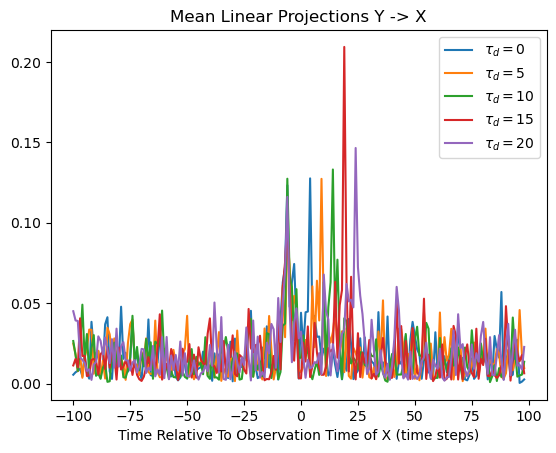

In [545]:
for i, row in results.iterrows():
    plt.plot(torch.arange(-p, p), row.proj_mag_y_to_x, label=r"$\tau_d = $" + f"{row.tau_d}")
plt.title('Mean Linear Projections Y -> X')
plt.xlabel('Time Relative To Observation Time of X (time steps)')
plt.legend()
plt.show()

# RNN Models

(array([2.0254e+04, 1.6902e+04, 1.2051e+04, 7.3620e+03, 3.5910e+03,
        1.6120e+03, 5.1700e+02, 1.7300e+02, 3.1000e+01, 7.0000e+00]),
 array([1.10896040e-06, 4.16600852e-01, 8.33200596e-01, 1.24980034e+00,
        1.66640008e+00, 2.08299983e+00, 2.49959957e+00, 2.91619931e+00,
        3.33279906e+00, 3.74939880e+00, 4.16599854e+00]),
 <BarContainer object of 10 artists>)

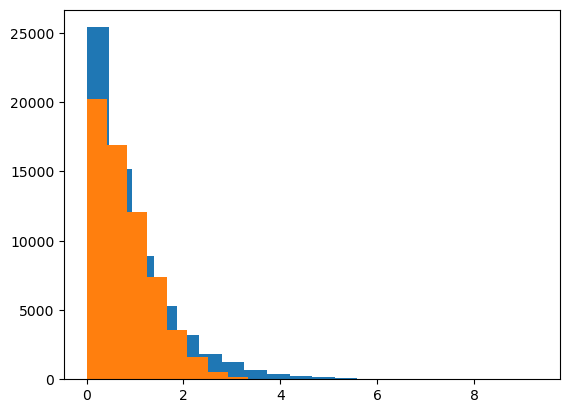

In [168]:

plt.hist(np.abs(np.random.exponential(scale=0.9, size=(N, N)).flatten()), bins=20)
plt.hist(np.abs(np.random.randn(N, N).flatten()))

In [394]:
N = 512
K = 2
W = np.zeros((N*K, N*K))
for i in range(K):
    W[N*i:N*(i+1), :][:, N*i:N*(i+1)] = np.random.randn(N, N)/np.sqrt(N)
for i in range(K):
    for j in range(K):
        if i != j:
            W[N*j:N*(j+1), :][:, N*i:N*(i+1)] = np.random.exponential(scale=1, size=(N, N))/np.sqrt(N)

# chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"
# W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))

            
# tau = 0.1
# dt = 0.01
dt = 1 # ms
tau = 10 # ms
t_end = 10 # s
T = int(t_end*1000/dt)

In [395]:
g = 1.9
g_comm = np.zeros((K, K, T))
for i in range(K):
    for j in range(K):
        if i == j:
            g_comm[i, j] = g
        elif i==0 and j == 1:
            for sec in range(int(t_end)):
                g_comm[i, j, int(sec/dt):int((sec+ 0.5)/dt)] = g

In [396]:
def rnn_update(t, x, W, dt, tau, N, K, g_comm):
    W_eff = W.copy()
    for i in range(K):
        W_eff[N*i:N*(i+1), :][:, N*i:N*(i+1)]*=g_comm[i, i, t]
    for i in range(K):
        for j in range(K):
            if i != j:
                W_eff[N*j:N*(j+1), :][:, N*i:N*(i+1)]*=g_comm[i, j, t]
    return (dt/tau)*(-x + W_eff @ np.tanh(x))
#     return (dt/tau)*(-x + g_comm[0, 0, t]*W @ np.tanh(x))


x0 = np.random.randn(N*K)
# t_span = [0, t_end]
t_eval = np.arange(t_span[0], t_span[1], dt)
x = np.zeros((T, N*K))
x[0] = x0*0.01
for t in tqdm(range(T-1)):
    x[t + 1] = x[t] + rnn_update(t, x[t], W, dt, tau, N, K, g_comm)
# sol = scipy.integrate.solve_ivp(lambda t, x: coupled_rnns(t, x, W=W, tau=tau, N=N, K=K, g_comm=g_comm), y0=x0, t_span=t_span, t_eval=t_eval)

  0%|          | 0/9999 [00:00<?, ?it/s]

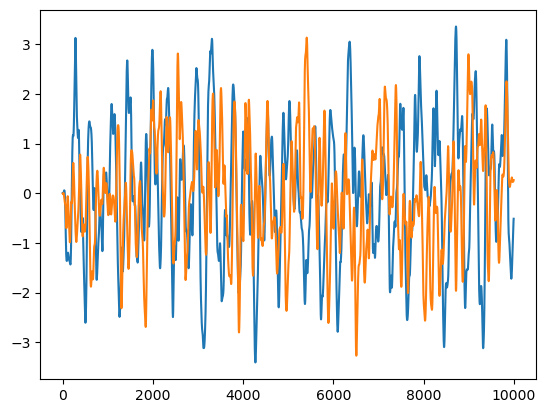

In [397]:
for k in range(K):
    plt.plot(x[:, N*k])

In [398]:
num_samples = 50
indices = []
for k in range(K):
    indices = np.hstack([indices, np.random.choice(N, size=(50, ), replace=False) + k*N]).astype(int)

In [400]:
delase = DeLASE(x[:, indices], p=20, use_torch=True, device='cuda')

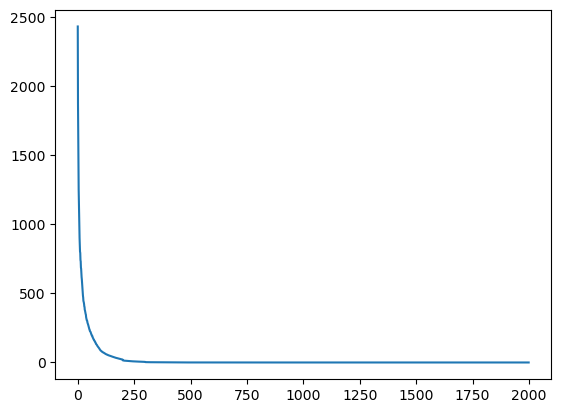

In [401]:
plt.plot(delase.S.cpu())

In [403]:
delase.compute_havok_dmd(explained_variance=0.99)

In [405]:
preds = delase.predict_havok_dmd(x[:, indices], use_real_coords=True)

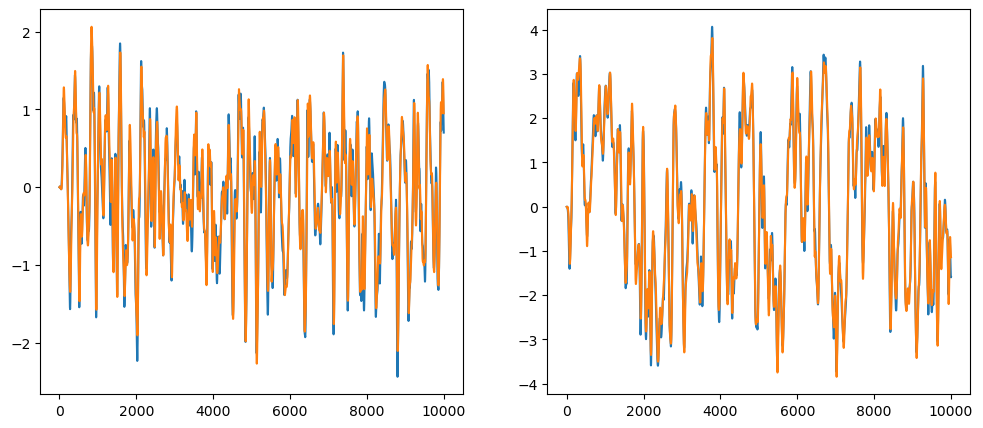

In [410]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x[:, indices[0]])
plt.plot(preds[:, 0].cpu())
plt.subplot(1, 2, 2)
plt.plot(x[:, indices[num_samples]])
plt.plot(preds[:, num_samples].cpu())
plt.show()

In [458]:
def network_inds(num_samples, network_num, p):
    inds = np.zeros(num_samples*p)
    for i in range(p):
        inds[i*num_samples:(i+1)*num_samples] = np.arange(num_samples) + network_num*num_samples
    
    return inds

In [416]:
comm_mat = delase.A[network_inds(num_samples, 1, delase.p), :][:, network_inds(num_samples, 0, delase.p)]

In [419]:
U, S, Vh = torch.linalg.svd(comm_mat)

In [421]:
explained_variance = torch.cumsum(S.cpu()**2/((S.cpu()**2).sum()), 0)
subspace_dim = int(np.argmax(explained_variance > 0.9999))
subspace_dim

47

In [423]:
V = Vh.T

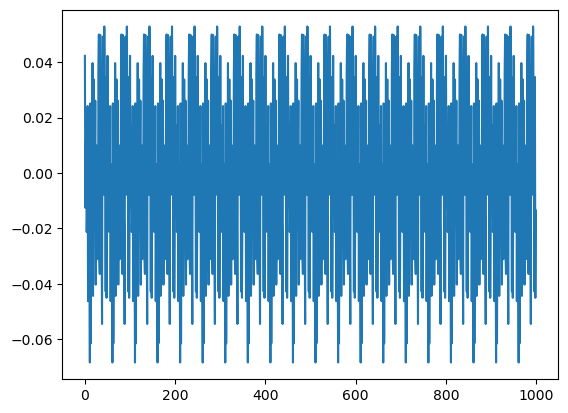

In [426]:
plt.plot(V.cpu()[:, 0])

In [424]:
comm_signal = (V[:, :subspace_dim].T@delase.H[:, network_inds(num_samples, 0, delase.p)].T).T

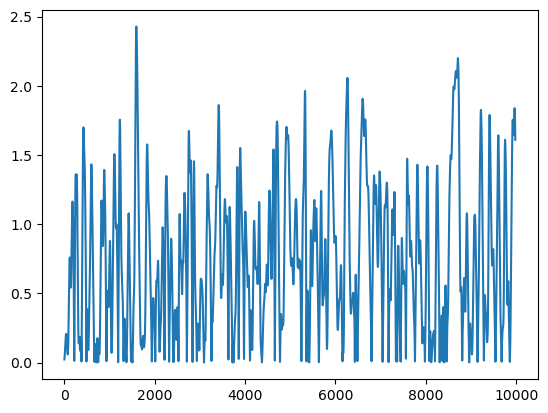

In [430]:
plt.plot(torch.abs(comm_signal[:, :subspace_dim].cpu().mean(axis=1)))

# Neural Stuff

# Load Some Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [6]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

# Load Directory

In [10]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

In [11]:
def load_window_from_chunks(window_start, window_end, directory, dimension_inds=None):
    dt = directory.end_time.iloc[0]/directory.end_ind.iloc[0]
    window_start = int(window_start/dt)
    window_end = int(window_end/dt)
    
    start_time_bool = directory.start_ind <= window_start
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(directory) else len(directory) - 1
    end_time_bool = directory.end_ind > window_end
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(directory) - 1
    
    window_data = None
    
    pos_in_window = 0
    for row_ind in range(start_row, end_row + 1):
        row = directory.iloc[row_ind]
        chunk = pd.read_pickle(row.filepath)
        if dimension_inds is None:
            dimension_inds = np.arange(chunk.shape[1])
        if window_data is None:
            window_data = np.zeros((window_end - window_start, len(dimension_inds)))
                
        if row.start_ind <= window_start:
            start_in_chunk = window_start - row.start_ind
        else:
            start_in_chunk = 0

        if row.end_ind <= window_end:
            end_in_chunk = chunk.shape[0]
        else:
            end_in_chunk = window_end - row.start_ind

        window_data[pos_in_window:pos_in_window + end_in_chunk - start_in_chunk] = chunk[start_in_chunk:end_in_chunk, dimension_inds]
        pos_in_window += end_in_chunk - start_in_chunk
                
    return window_data

# Load Data

In [12]:
session_info['drugStart']

array([1155.19066667, 2955.19066667])

In [31]:
wake_t = 300
anesthesia_t = 3000
area = 'vlPFC'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [32]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 20, directory, unit_indices)
wake_signal_unnormed = deepcopy(wake_signal)
wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 20, directory, unit_indices)
anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

In [33]:
wake_vlPFC = wake_signal.copy()
anesthesia_vlPFC = anesthesia_signal.copy()

In [34]:
wake_t = 300
anesthesia_t = 3000
area = 'CPB'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]

In [35]:
wake_signal = load_window_from_chunks(wake_t, wake_t + 20, directory, unit_indices)
wake_signal_unnormed = deepcopy(wake_signal)
wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 20, directory, unit_indices)
anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()

In [36]:
wake_CPB = wake_signal.copy()
anesthesia_CPB = anesthesia_signal.copy()